In [1]:
import pandas as pd
import numpy as np
import copy

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme()
sns.set_palette(sns.color_palette(['#851836', '#edbd17']))
sns.set_style("darkgrid")

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor

import xgboost as xgb

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

from sklearn.impute import SimpleImputer



TrainDataFrame = pd.read_csv('data/train.csv')
TestDataFrame = pd.read_csv('data/test.csv')

train_df = copy.deepcopy(TrainDataFrame)
test_df = copy.deepcopy(TestDataFrame)

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000

y = train_df['SalePrice']
train_df.drop(['SalePrice'], axis = 1, inplace = True)

categorical_columns = train_df.columns[train_df.dtypes == 'object']
numerical_float_columns = train_df.columns[train_df.dtypes == 'float64']
numerical_int_columns = train_df.columns[train_df.dtypes == 'int64']

In [2]:
imp_most_freq = SimpleImputer(strategy = 'most_frequent')
imp_median = SimpleImputer(strategy = 'median')
imp_mean = SimpleImputer(strategy = 'mean')


#We will fix all NAs.

train_df[numerical_float_columns] = imp_mean.fit_transform(train_df[numerical_float_columns])
test_df[numerical_float_columns] = imp_mean.transform(test_df[numerical_float_columns])

train_df[numerical_int_columns] = imp_median.fit_transform(train_df[numerical_int_columns])
test_df[numerical_int_columns] = imp_median.transform(test_df[numerical_int_columns])

train_df[categorical_columns] = imp_most_freq.fit_transform(train_df[categorical_columns])
test_df[categorical_columns] = imp_most_freq.transform(test_df[categorical_columns])

train_df_select = train_df[numerical_float_columns.append(numerical_int_columns)]
test_df_select = test_df[numerical_float_columns.append(numerical_int_columns)]


# # Let us see if adding Polynomial Features improves the outcomes.

# poly_ftrs = PolynomialFeatures(degree = 2, interaction_only = True)
# poly_array1 = poly_ftrs.fit_transform(train_df_select)

# train_df_select = pd.DataFrame(poly_array1, columns=poly_ftrs.get_feature_names_out(train_df_select.columns))

# poly_array2 = poly_ftrs.fit_transform(test_df_select)
# test_df_select = pd.DataFrame(poly_array2, columns=poly_ftrs.get_feature_names_out(test_df_select.columns))

# # Adding polynomial features seems to make the model perform worse.


# One Hot Encoding categorical features

train_df_select = train_df_select.join(pd.get_dummies(train_df[categorical_columns]))
test_df_select = test_df_select.join(pd.get_dummies(test_df[categorical_columns]))

#Fix missing cols in test set
missing_cols = set(train_df_select.columns) - set(test_df_select.columns)
for c in missing_cols:
    test_df_select[c] = 0
    
#Ensure order is the same in train and test sets
test_df_select = test_df_select[train_df_select.columns]


####

std_scle = StandardScaler()
train_df_select_scaled = std_scle.fit_transform(train_df_select)
test_df_select_scaled = std_scle.transform(test_df_select)

###

train_df_select.shape

(1460, 289)

0.12865205495740994


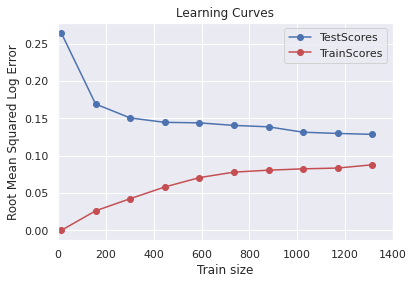

<Figure size 16000x16000 with 0 Axes>

In [3]:
# Let us print cross-validation scores and learning curves for the best model found above.

reg = GradientBoostingRegressor()

train_sizes = np.linspace(0.01, 1, num = 10)
train_sizes_abs, train_scores, test_scores = learning_curve(
    reg,
    train_df_select_scaled,
    y,
    train_sizes = train_sizes,
    scoring = "neg_mean_squared_log_error",
    cv = 10
)

plt.plot(
    train_sizes_abs,
    np.sqrt(-test_scores.mean(1)),
    "o-",
    color = "b",
    label = "TestScores"
)
plt.plot(
    train_sizes_abs,
    np.sqrt(-train_scores.mean(1)),
    "o-",
    color = "r",
    label = "TrainScores"
)
plt.xlabel("Train size")
plt.xlim((0, 1400))
plt.ylabel("Root Mean Squared Log Error")
plt.title("Learning Curves")
plt.legend()

plt.figure(figsize = (20, 20), dpi = 800)

print(np.sqrt(-test_scores.mean(1)[len(test_scores)-1]))

plt.show()

In [4]:
# We use the best model to make predictions on the test set and export these to a csv-file.

reg = GradientBoostingRegressor()
reg.fit(train_df_select_scaled, y)

y_pred = reg.predict(test_df_select_scaled)

export = pd.DataFrame(test_df['Id'])
export['SalePrice'] = y_pred
export['Id'] = export['Id'].astype('int')
export.to_csv('HousePrices.csv', index = False)